<font size = 5><u><b> Model Evaluation and Refinement </u></b><br> </font>

<p> We have built models and made predictions of vehicle prices. Now we will determine how accurate these predictions are. .<br>
Model evaluation tells us how our model performs in the real world and give us an estimate of how well the train model can predict new data. </p>

We will go through the following things in this notebook: <br>
            - Model Evaluation<br>
            - Over-fitting, Under-fitting and Model selection<br>
            - Ridge Regression<br>
            - Grid search <br>

In [2]:
import pandas as pd
            
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/module_5_auto.csv'
df = pd.read_csv(path)

#First, lets only use numeric data
df=df._get_numeric_data()
df.head()

,Unnamed: 0.1,Unnamed: 0,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,...,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,...,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,...,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,...,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


In [35]:
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np

In [24]:
#Functions for plotting

def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()
  
    
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
 
    xmax=max([xtrain.values.max(), xtest.values.max()])
    xmin=min([xtrain.values.min(), xtest.values.min()])
    x=np.arange(xmin, xmax, 0.1)

    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

<h3> Training and Testing </h3>
An important step in testing your model is to split your data into training and testing data. We will place the target data price in a separate dataframe y_data:

In [9]:
y_data= df['price']
x_data= df.drop('price', axis=1)

In [10]:
#Splitting the data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])


number of test samples : 21
number of training samples: 180


In [11]:
from sklearn.linear_model import LinearRegression
lre=LinearRegression()
lre.fit(x_train[['horsepower']], y_train)

LinearRegression()

In [12]:
#R^2 on test data
lre.score(x_test[['horsepower']], y_test)

0.3635875575078824

In [15]:
#R^2 on train data
lre.score(x_train[['horsepower']], y_train)

0.6619724197515103

<b> Cross Validation Score </b> <br>
Sometimes you do not have sufficient testing data; as a result, you may want to perform cross-validation.

<p> The parameter 'cv' determines the number of folds. In this case, it is 4.<br>
The default scoring is R^2. Each element in the array has the average R^2 value for the fold. 

In [18]:
from sklearn.model_selection import cross_val_score
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)
print(Rcross)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

[0.7746232  0.51716687 0.74785353 0.04839605]
The mean of the folds are 0.522009915042119 and the standard deviation is 0.2911839444756029


You can also use the function 'cross_val_predict' to predict the output. The function splits up the data into the specified number of folds, with one fold for testing and the other folds are used for training

In [19]:
from sklearn.model_selection import cross_val_predict
yhat = cross_val_predict(lre,x_data[['horsepower']], y_data,cv=4)
yhat[0:5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])

<h3> Overfitting, Underfitting and Model Selection </h3>
<b>Overfitting</b> occurs when the model fits the noise, but not the underlying process. <br>
Therefore, when testing your model using the test set, your model does not perform as well since it is modelling noise, not the underlying process that generated the relationship. 

In [27]:
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([ 7426.6731551 , 28323.75090803, 14213.38819709,  4052.34146983,
       34500.19124244])

In [29]:
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([11349.35089149,  5884.11059106, 11208.6928275 ,  6641.07786278,
       15565.79920282])

C:\Users\USER\AppData\Local\Temp\ipykernel_4796\2943998619.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\USER\AppData\Local\Temp\ipykernel_4796\2943998619.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.di

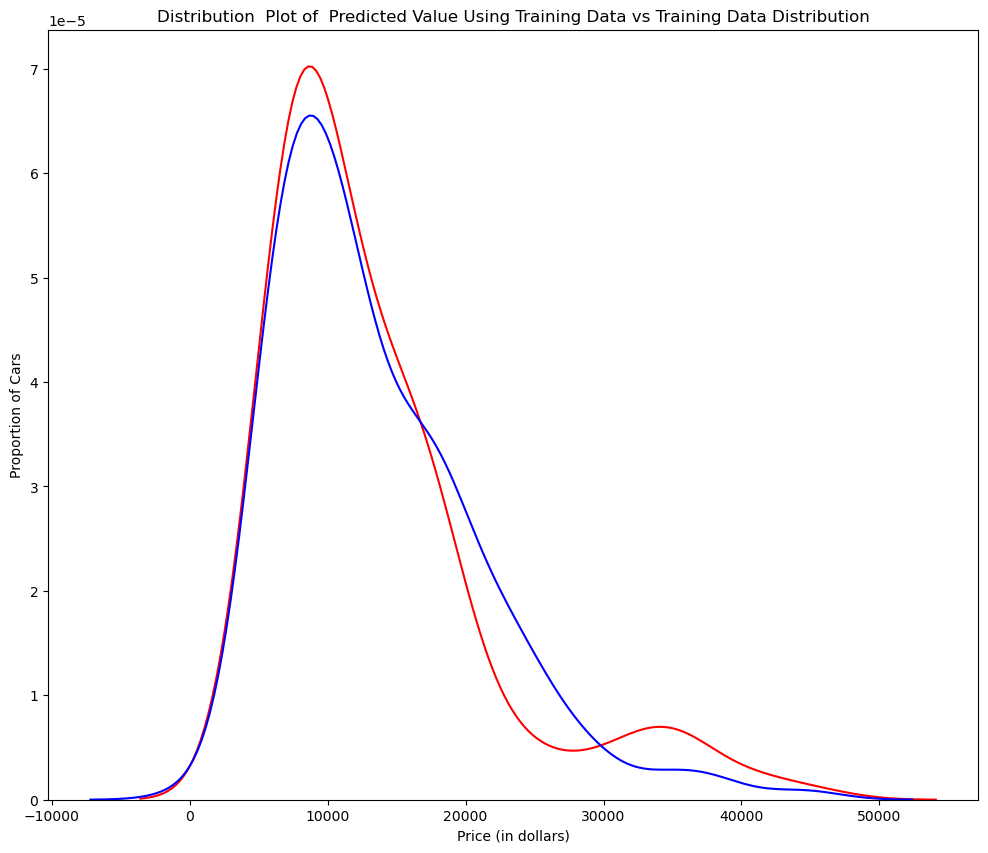

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

C:\Users\USER\AppData\Local\Temp\ipykernel_4796\2943998619.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\USER\AppData\Local\Temp\ipykernel_4796\2943998619.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.di

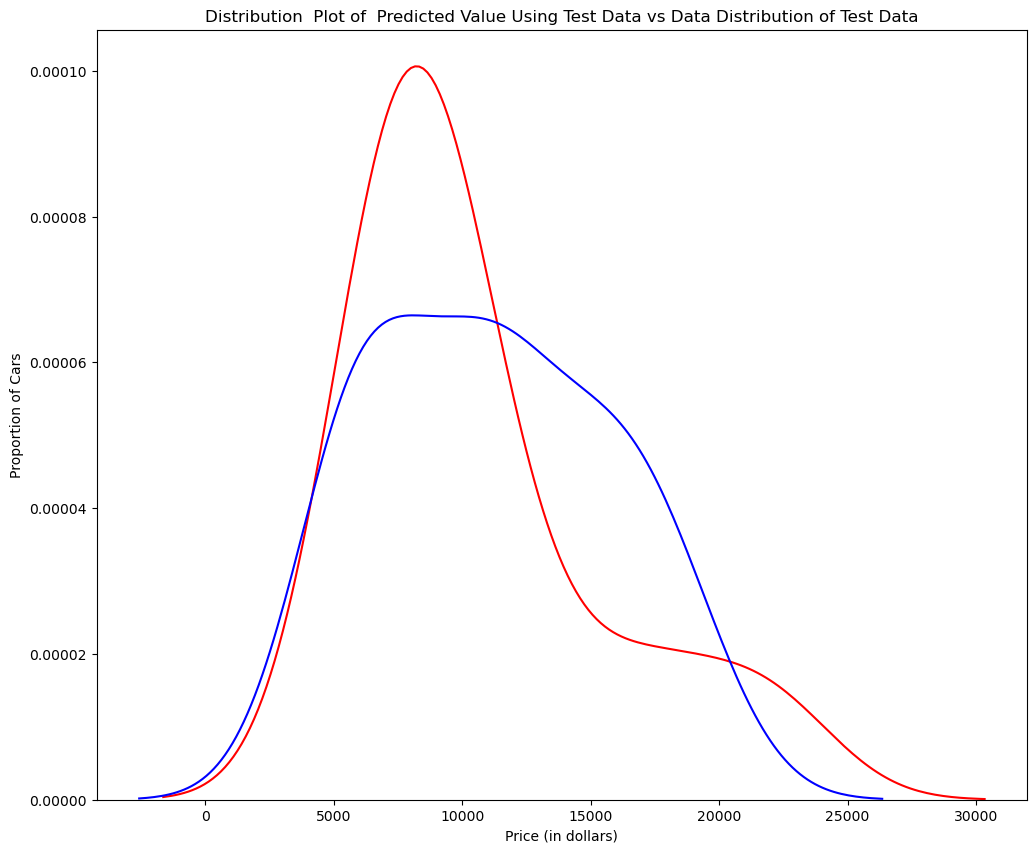

In [30]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Comparing Figure 1 and Figure 2, it is evident that the distribution of the test data in Figure 1 is much better at fitting the data. 

Predicted values: [ 6728.77492727  7308.09738048 12213.83912148 18893.06269972]
True values: [ 6295. 10698. 13860. 13499.]


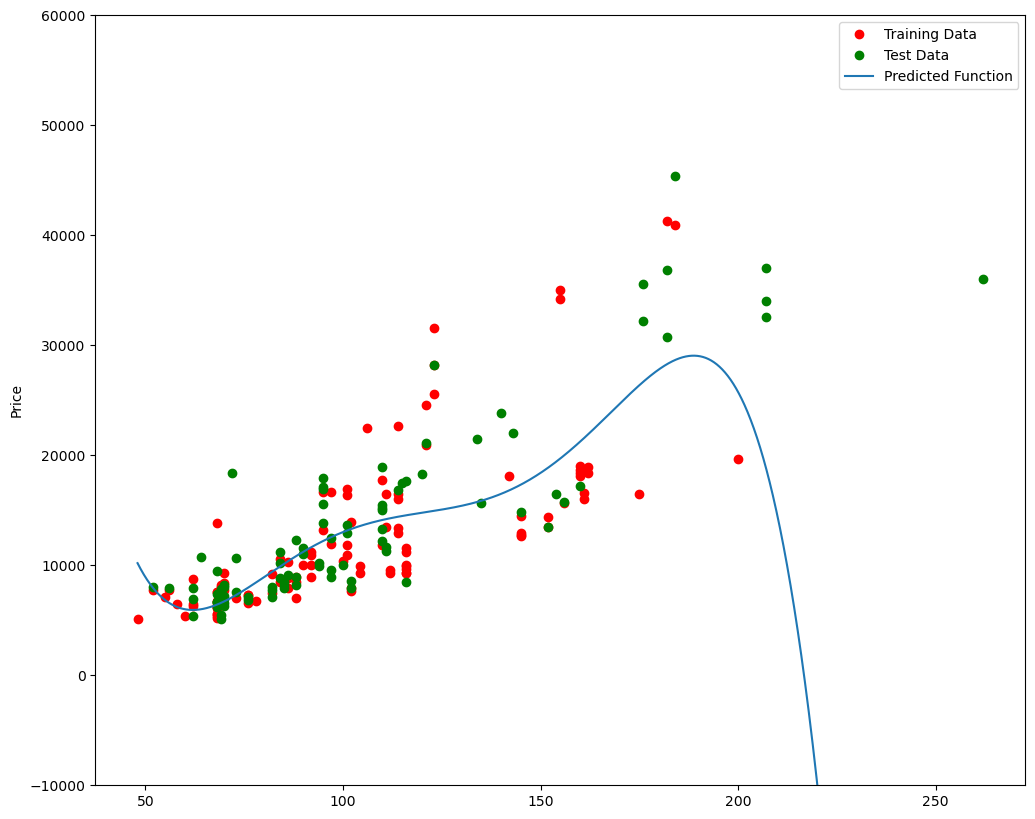

In [34]:
#Checkig for Overfitting
from sklearn.preprocessing import PolynomialFeatures
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])

poly = LinearRegression()
poly.fit(x_train_pr, y_train)
yhat = poly.predict(x_test_pr)

print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly,pr)


In [36]:
poly.score(x_train_pr, y_train)

0.5567716899817778

In [37]:
poly.score(x_test_pr, y_test)

-29.871838229908324

We see the R^2 for the training data is 0.5567 while the R^2 on the test data was -29.87. The lower the R^2, the worse the model. A negative R^2 is a sign of overfitting.